# POS tagging using modified Viterbi

### Data Preparation

In [2]:
#Importing libraries
# Importing libraries
import nltk
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import pprint, time
from nltk.tokenize import word_tokenize

In [3]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [4]:
nltk_data[:2]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')]]

In [5]:
# split data into training and validation set in the ratio 95:5

train_set,test_set = train_test_split(nltk_data,train_size=0.95,test_size=0.05,random_state = 101)

In [6]:
# creating list of tagged words from train and test set
train_tags = [tup for sent in train_set for tup in sent]
test_tags = [tup[0] for sent in test_set for tup in sent]
print(len(train_tags))
print(len(test_tags))

95547
5129


In [7]:
train_tags[1:5]

[('confirmed', 'VERB'), ('the', 'DET'), ('filing', 'NOUN'), ('but', 'CONJ')]

In [8]:
# Number of unique tags are present in training data
unique_tags = {tag for word,tag in train_tags}
print(len(unique_tags))
print(unique_tags)

12
{'PRT', 'VERB', 'DET', 'NUM', 'NOUN', '.', 'CONJ', 'X', 'PRON', 'ADP', 'ADV', 'ADJ'}


In [9]:
train_tagged_tokens = [tag[0] for tag in train_tags]
train_tagged_tokens[:5]

['Reliance', 'confirmed', 'the', 'filing', 'but']

In [10]:
train_tagged_pos_tokens = [tag[1] for tag in train_tags]
train_tagged_pos_tokens[:5]

['NOUN', 'VERB', 'DET', 'NOUN', 'CONJ']

In [11]:
training_vocabulary_set = set(train_tagged_tokens)
training_pos_tag_set = set(train_tagged_pos_tokens)

### POS Tagging algorithm using Hidden Markov Model (HMM)

In [12]:
# compute word given tag: Emission Probability

def word_given_tag(word, tag, train_bag = train_tags):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [13]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tags):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1,count_t1)

In [14]:
t2_given_t1('NOUN','DET')

(5284, 8281)

In [15]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(unique_tags), len(unique_tags)), dtype='float32')
for i, t1 in enumerate(list(unique_tags)):
    for j, t2 in enumerate(list(unique_tags)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [16]:
tags = pd.DataFrame(tags_matrix, columns = list(unique_tags), index=list(unique_tags))

In [17]:
tags

,PRT,VERB,DET,NUM,NOUN,.,CONJ,X,PRON,ADP,ADV,ADJ
PRT,0.001647,0.405272,0.097858,0.056672,0.247776,0.043822,0.002306,0.013509,0.017792,0.020099,0.010214,0.083031
VERB,0.030674,0.169249,0.134392,0.022851,0.110070,0.034934,0.005577,0.217506,0.035786,0.092022,0.081952,0.064988
DET,0.000242,0.039850,0.005676,0.022220,0.638087,0.017993,0.000483,0.045405,0.003744,0.009540,0.012438,0.204323
NUM,0.026504,0.018761,0.003276,0.184932,0.350208,0.117332,0.013699,0.210542,0.001489,0.036033,0.002978,0.034247
NOUN,0.043397,0.147667,0.012942,0.009542,0.263564,0.240604,0.042666,0.029175,0.004607,0.176514,0.017074,0.012248
.,0.002427,0.089095,0.173335,0.081003,0.222242,0.093320,0.057538,0.026971,0.066349,0.091342,0.052324,0.043963
CONJ,0.004649,0.156671,0.121339,0.039981,0.349140,0.034868,0.000465,0.008833,0.058113,0.052534,0.055323,0.118085
X,0.185232,0.203851,0.054742,0.002864,0.062381,0.163590,0.010662,0.076384,0.055538,0.142584,0.024984,0.017187
PRON,0.013017,0.485452,0.009954,0.006508,0.210949,0.040965,0.005360,0.089969,0.007657,0.022971,0.034074,0.073124
ADP,0.001390,0.008340,0.324709,0.062226,0.320967,0.039025,0.000962,0.034427,0.070031,0.016893,0.014006,0.107024


### Build the vanilla Viterbi based POS tagger

In [18]:
def Vanilla_Viterbi(words, train_bag = train_tags):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags.loc['.', tag]
            else:
                transition_p = tags.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [19]:
# Testing Vanilla Viterbi Algorithm on sampled test data

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]

In [20]:
# tagging the test sentences
start = time.time()
tagged_seq = Vanilla_Viterbi(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

Time taken in seconds:  22.70002818107605


In [21]:
# Let's check the accuracy of the vanilla viterbi algorithm

check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]

vanilla_viterbi_accuracy = len(check)/len(tagged_seq)

print("The accuracy of the Vanilla Viterbi Algorithm is:", vanilla_viterbi_accuracy)

The accuracy of the Vanilla Viterbi Algorithm is: 0.8849557522123894


In [22]:
# Incorrect tagged cases
incorrect_tagged = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
print(len(incorrect_tagged))
incorrect_tagged

13


[[('The', 'DET'), (('Contra', 'PRT'), ('Contra', 'NOUN'))],
 [('military', 'ADJ'), (('command', 'VERB'), ('command', 'NOUN'))],
 [('from', 'ADP'), (('Honduras', 'PRT'), ('Honduras', 'NOUN'))],
 [('0', 'X'), (('Sandinista', 'PRT'), ('Sandinista', 'NOUN'))],
 [('major', 'ADJ'), (('offensive', 'PRT'), ('offensive', 'NOUN'))],
 [('the', 'DET'), (('rebel', 'PRT'), ('rebel', 'NOUN'))],
 [('rebel', 'NOUN'), (('forces', 'VERB'), ('forces', 'NOUN'))],
 [('*-1', 'X'), (('Bucking', 'PRT'), ('Bucking', 'VERB'))],
 [('apparently', 'ADV'), (('drew', 'PRT'), ('drew', 'VERB'))],
 [('its', 'PRON'), (('Eveready', 'PRT'), ('Eveready', 'NOUN'))],
 [('what', 'PRON'), (('*T*-252', 'PRT'), ('*T*-252', 'X'))],
 [('*-1', 'X'), (('complaining', 'PRT'), ('complaining', 'VERB'))],
 [('ended', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))]]

#### We can see that all of unknown words have been tagged as 'NUM' as 'NUM' is the first tag in tag list and is assigned if unknown word is encountered i.e the emission probability is 0.

In [23]:
# Unknown words 
test_vocabulary_set = set([t for t in test_tagged_words])

unknown_words = list(test_vocabulary_set - training_vocabulary_set)
print("Total Unknown words :", len(unknown_words))
print("\n")
print("Unknown Words :", unknown_words)

Total Unknown words : 10


Unknown Words : ['rebel', 'Sandinista', 'drew', 'Bucking', 'complaining', 'offensive', 'Eveready', 'Honduras', '*T*-252', 'Contra']


### Solve the problem of unknown words

### Viterbi Modification-Technique I

#### Assign based on transition probabilities in case of unknown words since the emission probability for unknown word is zero.

In [24]:
# using transition probability in case of unknown words

def Viterbi_modif_1(words, train_bag = train_tags):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
        for tag in T:
            if key == 0:
                transition_p = tags.loc['.', tag]
            else:
                transition_p = tags.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # if probability is zero (unknown word) then use transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [27]:
# tagging the test sentences based on modified technique 1
start = time.time()
tagged_seq = Viterbi_modif_1(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

Time taken in seconds:  20.827343702316284


In [28]:
# Let's check the accuracy of the modified vanilla viterbi algorithm

check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]

Viterbi_modif_1_accuracy = len(check)/len(tagged_seq)

print("The accuracy based on Viterbi Modification-Technique I: ", Viterbi_modif_1_accuracy)

The accuracy based on Viterbi Modification-Technique I:  0.9469026548672567


#### Let us now apply weights based on the probability of tag occurance to the transition probabilities of tags.We will then use the resulting probability for predicting the unknown words.

In [29]:
# lets create a list containing tuples of POS tags and POS tag occurance probability, based on training data
tag_prob = []
total_tag = len([tag for word,tag in train_tags])
for t in tags:
    each_tag = [tag for word,tag in train_tags if tag==t]
    tag_prob.append((t,len(each_tag)/total_tag))

tag_prob

[('PRT', 0.03176447193527793),
 ('VERB', 0.1351167488251855),
 ('DET', 0.08666938784053921),
 ('NUM', 0.035145007169246546),
 ('NOUN', 0.2862674913916711),
 ('.', 0.11641391147812072),
 ('CONJ', 0.02251248076862696),
 ('X', 0.06576867928872701),
 ('PRON', 0.0273373313657153),
 ('ADP', 0.0978889970381069),
 ('ADV', 0.031597015081582885),
 ('ADJ', 0.06351847781719991)]

In [30]:
# Modifying the algorithm  to apply weights

def Viterbi_modif(words, train_bag = train_tags):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
       
        for tag in T:
            if key == 0:
                transition_p = tags.loc['.', tag]
            else:
                transition_p = tags.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
            # find POS tag occurance probability
            tag_p = [pair[1] for pair in tag_prob if pair[0]==tag ]
            
            # calculate the transition prob weighted by tag occurance probability.
            transition_p = tag_p[0]*transition_p             
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # if probability is zero (unknown word) then use weighted transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]                 
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [32]:
# tagging the test sentences based on modified technique 1
start = time.time()
tagged_seq = Viterbi_modif(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

Time taken in seconds:  23.579259872436523


In [33]:
# Let's check the accuracy of the above algorithm
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]

Viterbi_modif_accuracy = len(check)/len(tagged_seq)

print("The accuracy based on Viterbi Modification-Technique(with Weighted transition probabilities): ", Viterbi_modif_accuracy)

The accuracy based on Viterbi Modification-Technique(with Weighted transition probabilities):  0.9557522123893806


#### The weighted transition probabilties method has resulted in a much better accuracy of 95.57%

In [34]:
# let's check the incorrectly tagged words
[j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]

[(('command', 'VERB'), ('command', 'NOUN')),
 (('Sandinista', 'VERB'), ('Sandinista', 'NOUN')),
 (('Eveready', 'VERB'), ('Eveready', 'NOUN')),
 (('*T*-252', 'VERB'), ('*T*-252', 'X')),
 (('up', 'ADV'), ('up', 'PRT'))]

##### We can see that most of the incorrectly tagged words are tagged correctly using the modified algorithm# Unknown words 


#### Though the modified viterbi algorithm performs better than the original vanilla viterbi algorithm(It has achieved an accuracy of 95.57% compared to 89.38% of the original vanilla viterbi.

#### There is still an approx loss of 5%

#### Let us try to further reduce this loss

### Let's try with some Lexicon and Rule-Based Models for POS Tagging

##### Unigram tagger

In [35]:
# Lexicon (or unigram tagger)

unigram_tagger = nltk.UnigramTagger(train_set)
accuracy_unigram_tagger = unigram_tagger.evaluate(test_set)
print("The accuracy of the Unigram Tagger is -", accuracy_unigram_tagger)

The accuracy of the Unigram Tagger is - 0.906999415090661


#### Let us now try and combine the unigram tagger with a rule based regex tagger.

In [36]:
# patterns for tagging using a rule based tagger
patterns = [
    (r'.*\'s$', 'NOUN'),                     
    (r'.*s$', 'NOUN'),                      
    (r'^[aA-zZ].*[0-9]+','NOUN'),            
    (r'.*ness$', 'NOUN'),                   
    (r'.*', 'NOUN'), 
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),     
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'),       
    (r'.*ly$', 'ADV'),                         
    (r'^[0-9]+(.[0-9]+)?$', 'NUM'),          
    (r'(The|the|A|a|An|an)$', 'DET')
    ]

In [37]:
# Rule-Based tagger

rule_based_tagger = nltk.RegexpTagger(patterns)

# unigram tagger backed up by the rule-based tagger
rule_based_unigram_tagger = nltk.UnigramTagger(train_set, backoff = rule_based_tagger)

accuracy_rule_based_unigram_tagger = rule_based_unigram_tagger.evaluate(test_set)

print("The accuracy of the Unigram Tagger combined with the RegexpTagger is -", accuracy_rule_based_unigram_tagger)

The accuracy of the Unigram Tagger combined with the RegexpTagger is - 0.9395593682979139


##### Bigram tagger

In [38]:
bigram_tagger = nltk.BigramTagger(train_set, backoff=rule_based_unigram_tagger)
bigram_tagger.evaluate(test_set)
accuracy_bigram_tagger = bigram_tagger.evaluate(test_set)
print("The accuracy of the Bigram Tagger backed up by the unigram tagger is -",accuracy_bigram_tagger)

The accuracy of the Bigram Tagger backed up by the unigram tagger is - 0.9424839149931761


##### Trigram tagger

In [39]:
trigram_tagger = nltk.TrigramTagger(train_set, backoff = bigram_tagger)
trigram_tagger.evaluate(test_set)
accuracy_trigram_tagger = trigram_tagger.evaluate(test_set)
print("The accuracy of the Trigram Tagger backed up by the bigram tagger is -", accuracy_trigram_tagger)

The accuracy of the Trigram Tagger backed up by the bigram tagger is - 0.9426788847728602


### Viterbi Modification-Technique II

#### We see that the Trigram Tagger backed up by the bigram tagger gives an accuracy of about 94.26%. Let's now try to modify the viterbi algorithm to use this trigram tagger as a back-off.

#### When the viterbi algorithm is not able to tag an unknown word, it uses the rule-based tagger.

In [40]:
# A trigram tagger backed off by a rule based tagger.

def trigram_tagger(word, train_set = train_set):
    
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb

    (r'.*ly$', 'ADV'),
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # eg.- kinderganteners, autobioghapgers
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
        
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
        
    (r'.*', 'NOUN')
    ]

    regex_based_tagger = nltk.RegexpTagger(patterns)

    # trigram backed up by the regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff = regex_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

In [41]:
# viterbi with handling for unknown words from regex tagger

def Viterbi_Trigram_Tagger(words, train_bag = train_tags):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        # unknown words from trigram taggr
        if word not in training_vocabulary_set:
            unk_word_tag=trigram_tagger(word)
            for sent in unk_word_tag:
                for tup in sent:
                    state.append(tup[1])
        # rest remains same            
        else:            
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags.loc['.', tag]
                else:
                    transition_p = tags.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
             # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
            
    return list(zip(words, state))
            

#### Evaluating tagging accuracy

In [42]:
# tagging the test sentences based on Viterbi Trigram Tagger
start = time.time()
tagged_seq = Viterbi_Trigram_Tagger(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

Time taken in seconds:  50.93869614601135


In [43]:
# Viterbi Trigram Tagger Accuracy
viterbi_trigram_word_check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
viterbi_trigram_accuracy = len(viterbi_trigram_word_check)/len(tagged_seq) 
print('Viterbi Trigram Tagger Accuracy: ', viterbi_trigram_accuracy)

Viterbi Trigram Tagger Accuracy:  0.9734513274336283


#### The Viterbi Trigram Tagger Algorithm has resulted in a higher accuracy of 97.34%

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [100]:
accuracy_list = [['Vanilla Viterbi', vanilla_viterbi_accuracy*100], 
                  ['Vanilla Viterbi Modified', Viterbi_modif_accuracy*100], 
                  ['Unigram Tagger', accuracy_unigram_tagger * 100],
                  ['Unigram + RegexpTagger', accuracy_rule_based_unigram_tagger * 100],
                  ['Bigram Tagger + Unigram_tagger', accuracy_bigram_tagger*100],
                  ['Trigram Tagger + Bigram_tagger', accuracy_trigram_tagger*100],
                  ['Viterbi + Trigram_tagger', viterbi_trigram_accuracy*100]]

In [101]:
accuracy_list_df = pd.DataFrame(accuracy_list, columns = ['Tagging Algorithm', 'Tagging Accuracy'])
accuracy_list_df

,Tagging Algorithm,Tagging Accuracy
0,Vanilla Viterbi,88.495575
1,Vanilla Viterbi Modified,95.575221
2,Unigram Tagger,90.699942
3,Unigram + RegexpTagger,93.955937
4,Bigram Tagger + Unigram_tagger,94.248391
5,Trigram Tagger + Bigram_tagger,94.267888
6,Viterbi + Trigram_tagger,97.345133


In [102]:
accuracy_list_df.set_index('Tagging Algorithm', drop = True, inplace = True)
accuracy_list_df

,Tagging Accuracy
Tagging Algorithm,
Vanilla Viterbi,88.495575
Vanilla Viterbi Modified,95.575221
Unigram Tagger,90.699942
Unigram + RegexpTagger,93.955937
Bigram Tagger + Unigram_tagger,94.248391
Trigram Tagger + Bigram_tagger,94.267888
Viterbi + Trigram_tagger,97.345133


<AxesSubplot:xlabel='Tagging Algorithm'>

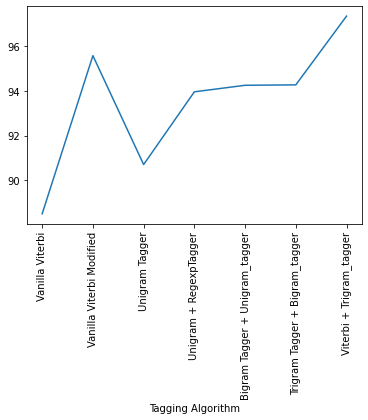

In [103]:
#Line plot to compare the Tagging accuracy of different algorithms
accuracy_list_df.plot.line(rot = 90, legend = False)

### Let us now check the tagging accuracies for the Sample test sentences

In [104]:
open_sample=open("Sample Test Sentences.txt")
read_sample=open_sample.read()

In [105]:
sample_test_sentences=read_sample.splitlines()
sample_test_sentences

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [106]:
sample_test_tokenized_sents = [word_tokenize(sent) for sent in sample_test_sentences]
sample_test_corpus_pos_tags = nltk.pos_tag_sents(sample_test_tokenized_sents, tagset = 'universal')
sample_test_corpus_pos_tags

[[('Android', 'NOUN'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'NOUN'),
  ('.', '.')],
 [('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'NOUN'),
  ('since', 'ADP'),
  ('2011', 'NUM'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'NUM'),
  ('.', '.')],
 [('Google', 'NOUN'),
  ('and', 'CONJ'),
  ('Twitter', 'NOUN'),
  ('made', 'VERB'),
  ('a', 'DET'),
  ('deal', 'NOUN'),
  ('in', 'ADP'),
  ('2015', 'NUM'),
  ('that', 'DET'),
  ('gave', 'VERB'),
  ('Google', 'NOUN'),
  ('access', 'NOUN'),
  ('to', 'PRT'),
  ('Twitter', 'NOUN'),
  ("'s", 'PRT'),
  ('firehose', 'NOUN'),
  ('.', '.')],
 [('Twitter', 'NOUN'),
  ('is', 'VERB'),
  ('an', 'DET'),
  ('online', 'ADJ'),
  ('news', 'NOUN'),
  ('and', 'CONJ'

In [107]:
# list of untagged words from the sample test data provided
sample_test_tagged_words = [tup[0] for sent in sample_test_corpus_pos_tags for tup in sent]

# list of tagged words
sample_test_run_base = [tup for sent in sample_test_corpus_pos_tags for tup in sent]

In [108]:
sample_test_tagged_words[:5]

['Android', 'is', 'a', 'mobile', 'operating']

### Testing Accuracy of Original Vanilla Viterbi Algorithm on the Sample Test Data

In [109]:
start = time.time()
sample_test_tagged_seq = Vanilla_Viterbi(sample_test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

sample_test_check = [i for i, j in zip(sample_test_tagged_seq, sample_test_run_base) if i == j]
vanilla_viterbi_accuracy_sample = len(sample_test_check)/len(sample_test_tagged_seq)

print("The accuracy of the Vanilla Viterbi Algorithm on the sample test data is :", vanilla_viterbi_accuracy_sample)

Time taken in seconds:  82.97630405426025
The accuracy of the Vanilla Viterbi Algorithm on the sample test data is : 0.7513812154696132


### Testing Accuracy of Modified Vanilla Viterbi Algorithm on the Sample Test Data

In [110]:
start = time.time()
sample_test_tagged_seq = Viterbi_modif(sample_test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

sample_test_check = [i for i, j in zip(sample_test_tagged_seq, sample_test_run_base) if i == j]
Viterbi_modif_accuracy_sample = len(sample_test_check)/len(sample_test_tagged_seq)

print("The accuracy based on Viterbi Modification-Technique I on the sample test data: ", Viterbi_modif_accuracy_sample)

Time taken in seconds:  83.40377497673035
The accuracy based on Viterbi Modification-Technique I on the sample test data:  0.9060773480662984


### Testing Accuracy of Viterbi Trigram Tagger Algorithm on the Sample Test Data

In [111]:
start = time.time()
sample_test_tagged_seq = Viterbi_Trigram_Tagger(sample_test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

sample_test_check = [i for i, j in zip(sample_test_tagged_seq, sample_test_run_base) if i == j] 
viterbi_trigram_accuracy_sample = len(sample_test_check)/len(sample_test_tagged_seq) 

print('The accuracy based on Viterbi Trigram Tagger on sample test data : ', viterbi_trigram_accuracy_sample)

Time taken in seconds:  259.29844093322754
The accuracy based on Viterbi Trigram Tagger on sample test data :  0.9281767955801105


### Comparing the accuracies of the 3 algorithm on sample test data

In [112]:
sample_accuracy_list = [['Vanilla Viterbi', vanilla_viterbi_accuracy_sample*100], 
                  ['Vanilla Viterbi Modified', Viterbi_modif_accuracy_sample*100], 
                  ['Viterbi + Trigram_tagger', viterbi_trigram_accuracy_sample*100]]

sample_accuracy_list_df = pd.DataFrame(sample_accuracy_list, columns = ['Tagging Algorithm', 'Tagging Accuracy'])

sample_accuracy_list_df.set_index('Tagging Algorithm', drop = True, inplace = True)
sample_accuracy_list_df

,Tagging Accuracy
Tagging Algorithm,
Vanilla Viterbi,75.138122
Vanilla Viterbi Modified,90.607735
Viterbi + Trigram_tagger,92.817680


<AxesSubplot:xlabel='Tagging Algorithm'>

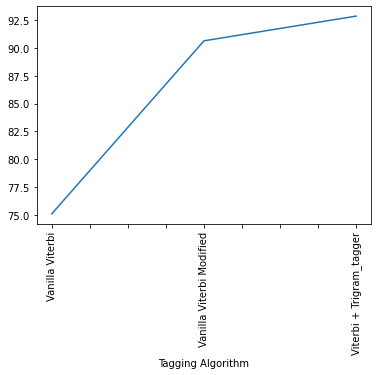

In [113]:
#Line plot to compare the Tagging accuracy of different algorithms
sample_accuracy_list_df.plot.line(rot = 90, legend = False)

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

#### Test case 1

In [114]:
sentence_test_1 = sample_test_sentences[2]
print("Sample Sentence:",sentence_test_1)
words = word_tokenize(sentence_test_1)
tagged_seq = Vanilla_Viterbi(words)
print(tagged_seq)

Sample Sentence: Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.
[('Google', 'PRON'), ('and', 'CONJ'), ('Twitter', 'PRON'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'PRON'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'PRON'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'PRON'), ("'s", 'VERB'), ('firehose', 'PRON'), ('.', '.')]


In [115]:
tagged_seq_modified = Viterbi_Trigram_Tagger(words)
print(tagged_seq_modified)

[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]


#### Test case 2

In [116]:
sentence_test_2 = sample_test_sentences[4]
print("Sample Sentence:",sentence_test_2)
words = word_tokenize(sentence_test_2)
tagged_seq = Vanilla_Viterbi(words)
print(tagged_seq)

Sample Sentence: Before entering politics, Donald Trump was a domineering businessman and a television personality.
[('Before', 'ADP'), ('entering', 'VERB'), ('politics', 'NOUN'), (',', '.'), ('Donald', 'NOUN'), ('Trump', 'NOUN'), ('was', 'VERB'), ('a', 'DET'), ('domineering', 'PRON'), ('businessman', 'NOUN'), ('and', 'CONJ'), ('a', 'DET'), ('television', 'NOUN'), ('personality', 'PRON'), ('.', '.')]


In [117]:
tagged_seq_modified = Viterbi_Trigram_Tagger(words)
print(tagged_seq_modified)

[('Before', 'ADP'), ('entering', 'VERB'), ('politics', 'NOUN'), (',', '.'), ('Donald', 'NOUN'), ('Trump', 'NOUN'), ('was', 'VERB'), ('a', 'DET'), ('domineering', 'VERB'), ('businessman', 'NOUN'), ('and', 'CONJ'), ('a', 'DET'), ('television', 'NOUN'), ('personality', 'NOUN'), ('.', '.')]


#### Test case 3

In [118]:
sentence_test_3 = sample_test_sentences[0]
print("Sample Sentence:",sentence_test_3)
words = word_tokenize(sentence_test_3)
tagged_seq = Vanilla_Viterbi(words)
print(tagged_seq)

Sample Sentence: Android is a mobile operating system developed by Google.
[('Android', 'PRON'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'PRON'), ('.', '.')]


In [119]:
tagged_seq_modified = Viterbi_Trigram_Tagger(words)
print(tagged_seq_modified)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]


### As per Sample test cases, Few Corrections are as follows:

##### TEST CASE 1.Google: NUM to NOUN
##### TEST CASE 2.personality: NUM to NOUN
##### TEST CASE 3.Android: NUM to NOUN

### As per Treebank dataset of NLTK, Few Corrections are as follows:

##### Contra:correctly tagged as NOUN
##### Honduras:correctly tagged as NOUN
##### complaining: correctly tagged as VERB
##### Bucking: correctly tagged as VERB
##### Sandinista: correctly tagged as NOUN
##### Eveready: correctly tagged as NOUN
##### drew: correctly tagged as VERB

### <font color='Blue'>**---------------------------------------------------------------END---------------------------------------------------------------**</font>